In [2]:
from utils import *
import matplotlib.pyplot as plt

In [3]:
def generate_function(k, point_number=1, x_range_length = 1, test_data=100):
    '''
    generate data points with prior function, introduce random noise
    k: poly rate, each coefficient is a random number in (0, 1)
    point_number: number of data points
    x_range_length: x range of training data is (-x_range_length/2, x_range_length/2), but for testing data is (-x_range_length, x_range_length)
    '''
    data = []
    test_data_set = []
    #coeffs = [0.86,0.5,0.43]
    coeffs = []
    for _ in range(k+1):
        coeffs.append(np.random.rand())
    for _ in range(point_number):
        x = np.random.rand() * x_range_length - x_range_length / 2
        y = 0
        for i in range(k+1):
            y += coeffs[i] * (x ** i)
        y += np.random.normal(0, np.abs(y/500)) # add some noise for obversing the effect of overfitting
        data.append([x, y])
    for _ in range(test_data):
        x = np.random.rand() * x_range_length * 2 - x_range_length
        y = 0
        for i in range(k+1):
            y += coeffs[i] * (x ** i)
        test_data_set.append([x, y]) #no noise for testing data
    return np.array(data), coeffs, np.array(test_data_set)
    

In [7]:
# raw data generation
def test_fitting(poly_rate, fitting_poly_rate, number_of_training_points=10, number_of_testing_points=100, x_range_length=1, example=False, test=False, new_data=False):
    '''
    poly_rate: the rate of the correct polynomial
    fitting_poly_rate: the rate of the polynomial we are fitting
    number_of_training_points: number of training data points
    number_of_testing_points: number of testing data points
    x_range_length: x range of training data is (-x_range_length/2, x_range_length/2), but for testing data is (-x_range_length, x_range_length)
    example: whether to show the fitting example
    test: whether to return the relative error of the test data
    '''
    if new_data:
        raw_data, correct_coeffs, test_data_set = generate_function(poly_rate, number_of_training_points, x_range_length, number_of_testing_points)
        # save data
        np.save('./lse_data/raw_data.npy', raw_data)
        np.save('./lse_data/correct_coeffs.npy', correct_coeffs)
        np.save('./lse_data/test_data_set.npy', test_data_set)
    else:
        raw_data = np.load('./lse_data/raw_data.npy')
        correct_coeffs = np.load('./lse_data/correct_coeffs.npy')
        test_data_set = np.load('./lse_data/test_data_set.npy')
    correct_poly_string = 'y = '
    for i in range(len(correct_coeffs)):
        correct_poly_string += str(correct_coeffs[i]) + 'x^' + str(i) + ' + '
    correct_poly_string = correct_poly_string[:-2]

    # fitting
    raw_matrix_data = np.zeros((len(raw_data), fitting_poly_rate + 1))
    for i in range(len(raw_data)):
        for j in range(fitting_poly_rate + 1):
            raw_matrix_data[i][j] = raw_data[i][0] ** j

    raw_column_data = np.zeros(len(raw_data))
    for i in range(len(raw_data)):
        raw_column_data[i] = raw_data[i][1]
    fitting_coeffs, error = least_square_fitting(raw_matrix_data, raw_column_data)
    fitting_coeffs = fitting_coeffs.real
    training_relative_error = error / np.linalg.norm(raw_column_data)

    # error calculation
    fitting_poly_string = 'y = '
    for i in range(len(fitting_coeffs)):
        fitting_poly_string += str(fitting_coeffs[i]) + 'x^' + str(i) + ' + '
    fitting_poly_string = fitting_poly_string[:-2]

    if example:
        print('correct polynomial is ', correct_poly_string)
        print('the fitting polynomial is ', fitting_poly_string)
        print('relative error is ', training_relative_error)
        plt.figure(figsize=(7.6, 5.7))
        plt.scatter(raw_data[:, 0], raw_data[:, 1], color='#EF767A',alpha=0.7,marker='^', s=200)
        plt.scatter(test_data_set[:, 0], test_data_set[:, 1], color='#48C0AA',alpha=0.7, marker='o', s=200)
        x = np.linspace(np.min(test_data_set[:,0]), np.max(test_data_set[:, 0]), 100)
        y = np.zeros(100)
        for i in range(100):
            for j in range(fitting_poly_rate + 1):
                y[i] += fitting_coeffs[j] * (x[i] ** j)
        plt.plot(x, y, color='#456990', linewidth=2)
        x_corrrect = np.linspace(np.min(test_data_set[:,0]), np.max(test_data_set[:, 0]), 100)
        y_correct = np.zeros(100)
        for i in range(100):
            for j in range(poly_rate + 1):
                y_correct[i] += correct_coeffs[j] * (x_corrrect[i] ** j)
        plt.plot(x_corrrect, y_correct, color='#AB84B6', linewidth=2, alpha=0.7, linestyle='--')
        plt.subplots_adjust(bottom=0.15, left=0.2)
        plt.xticks(np.linspace(-x_range_length, x_range_length, 5))
        plt.yticks(np.linspace(min(np.min(y), np.min(test_data_set[:,1])), max(np.max(y), np.max(test_data_set[:,1])), 3))
        plt.tick_params(labelsize=24)
        plt.xlabel('x', fontsize=36)
        plt.ylabel('y', fontsize=36)
        plt.legend(['training data', 'test data', 'fitting_curve', 'correct_curve'], shadow=True,fontsize=20)
        if fitting_poly_rate > poly_rate:
            #plt.title('overfitting case', fontsize=15)
            plt.savefig('./figures/overfitting.pdf', dpi=300, format='pdf')
        elif fitting_poly_rate < poly_rate:
            #plt.title('underfitting case',fontsize=15)
            plt.savefig('./figures/underfitting.pdf',dpi=300, format='pdf')
        else:
            #plt.title('appropriate fitting case',fontsize=15)
            plt.savefig('./figures/appropriate.pdf',dpi=300, format='pdf')
        
        # plt.savefig('save.png')
        # plt.show()

    if test:
        test_relative_error = np.zeros(len(test_data_set))
        for i in range(len(test_data_set)):
            y = 0
            for j in range(fitting_poly_rate + 1):
                y += fitting_coeffs[j] * (test_data_set[i][0] ** j)
            test_relative_error[i] = (y - test_data_set[i][1])
        test_relative_error = np.linalg.norm(test_relative_error) / np.linalg.norm(test_data_set[:, 1])

        return training_relative_error, np.mean(test_relative_error)

    return training_relative_error

correct polynomial is  y = 0.86x^0 + 0.5x^1 + 0.43x^2 
the fitting polynomial is  y = 0.8602022003785942x^0 + 0.5536233120594463x^1 + 0.4859044798418016x^2 
relative error is  0.042716369025814875


(0.042716369025814875, 0.04201332585382543)

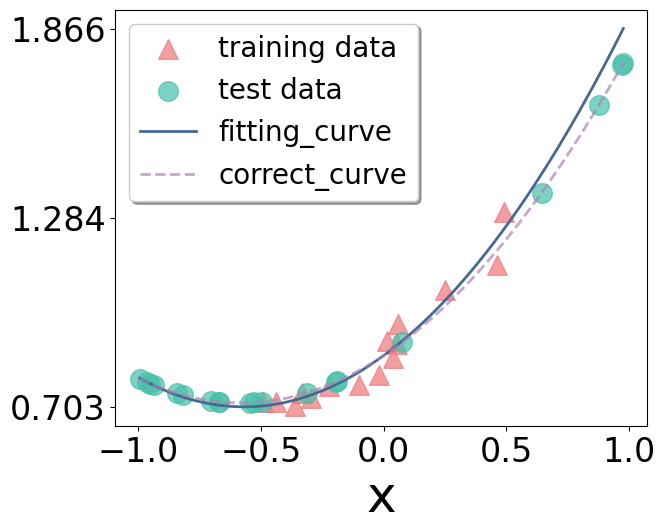

In [5]:
test_fitting(2, 2, 15, 20, 1, example=True, test=True, new_data=False)

correct polynomial is  y = 0.86x^0 + 0.5x^1 + 0.43x^2 
the fitting polynomial is  y = 0.8614652431719546x^0 + 0.6402781743702709x^1 + 0.4969217501717245x^2 + -0.47379047622830767x^3 
relative error is  0.04147697314727668


(0.04147697314727668, 0.19267564810489754)

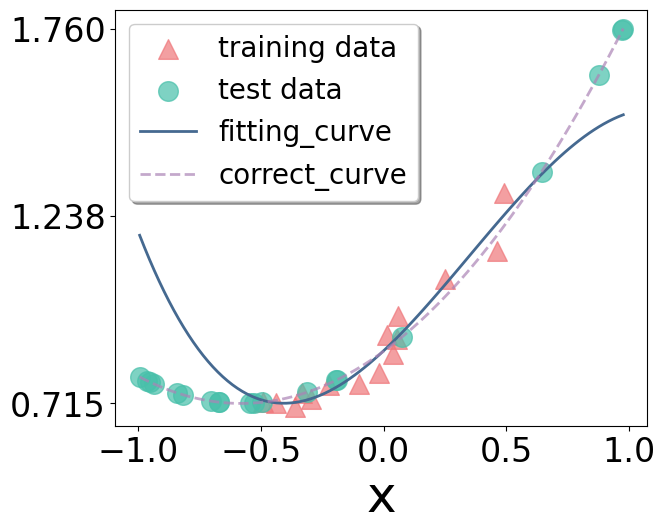

In [6]:
test_fitting(2, 3, 15, 20, 1, example=True, test=True, new_data=False)

correct polynomial is  y = 0.86x^0 + 0.5x^1 + 0.43x^2 
the fitting polynomial is  y = 0.9035830555033374x^0 + 0.5489144135657243x^1 
relative error is  0.06510009135498489


(0.06510009135498489, 0.2491390546468093)

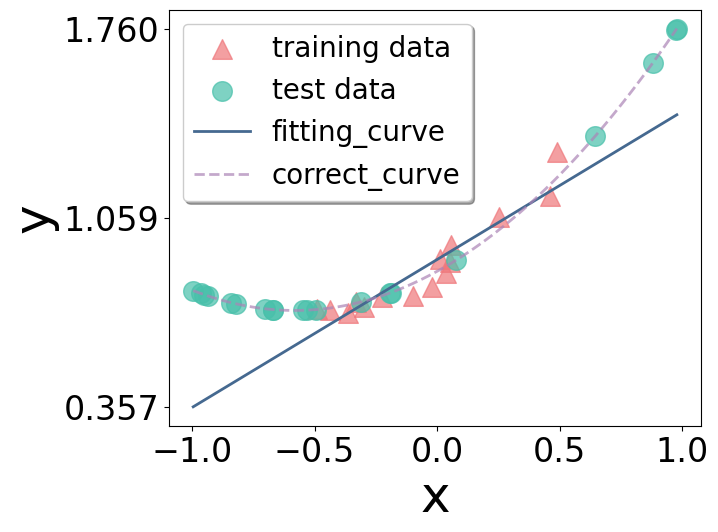

In [8]:
test_fitting(2, 1, 15, 20, 1, example=True, test=True, new_data=False)

In [9]:
# test
record = []
for poly_rate in range(1, 8):
    tmp = []
    for fitting_poly_rate in range(1, 8):
        test_relative_error = 0
        for _ in range(100):
            _, tmp_test_relative_error = test_fitting(poly_rate, fitting_poly_rate, 10, 1000, 10, test=True,new_data=True)
            test_relative_error += tmp_test_relative_error
        tmp.append(test_relative_error/100)
    record.append(tmp)

record = np.array(record)
print(record)


[[9.01637701e-04 2.60355399e-03 1.06733979e-02 5.06268269e-02
  2.63250670e-01 3.77444292e+00 1.63059977e+02]
 [8.08738058e-01 1.42926953e-03 5.48876124e-03 2.47092233e-02
  1.96748508e-01 2.22969129e+00 3.74640554e+01]
 [8.00213793e-01 8.15555824e-01 2.33964156e-03 1.03495764e-02
  5.62762321e-02 4.73523318e-01 1.72163495e+01]
 [9.61069012e-01 7.45998613e-01 7.96593674e-01 4.77490899e-03
  2.90110168e-02 2.90580027e-01 1.38346109e+00]
 [9.58686534e-01 9.58323743e-01 7.14581033e-01 7.93840245e-01
  1.36643620e-02 7.91312003e-02 3.56416221e+00]
 [9.93688112e-01 9.41678453e-01 9.57106429e-01 6.71035018e-01
  7.45762807e-01 5.10481042e-02 1.55984080e+00]
 [9.91457553e-01 9.88021703e-01 9.22252027e-01 9.52232703e-01
  6.39653305e-01 8.65689486e-01 1.62118581e-01]]


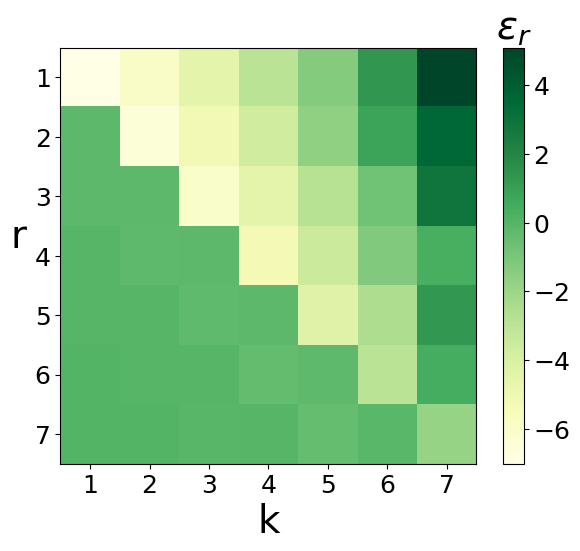

In [14]:
# plot as heatmap in log scale
# style is the green one
plt.figure(figsize=(7.6, 5.7))
plt.imshow(np.log(record), cmap='YlGn', interpolation='nearest')
plt.xticks(range(7), range(1, 8))
plt.yticks(range(7), range(1, 8))
plt.tick_params(labelsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
cb.ax.set_title('$\epsilon_r$', fontsize=28, loc='center')
plt.xlabel('k',fontsize=28)
plt.ylabel('r',fontsize=28, rotation=0, labelpad=12)
#plt.title('log relative error',fontsize=15)
plt.subplots_adjust(bottom=0.15, left=0.2)
plt.savefig('./figures/fitting_b.pdf',dpi=300, format='pdf')

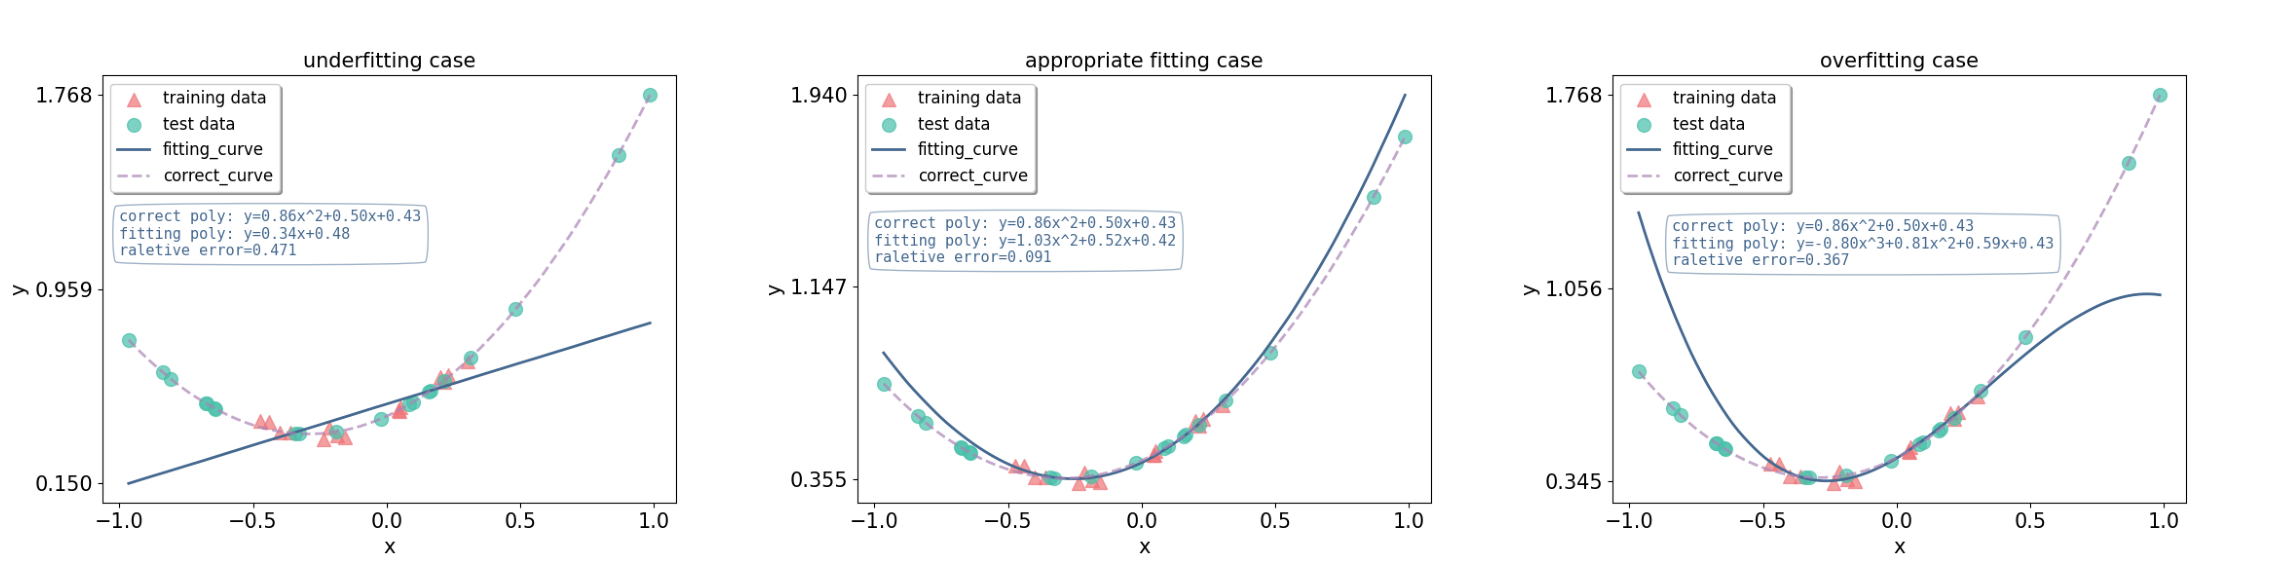

In [416]:
# read underfitting_example.png, overfitting_example.png, appropriate_fitting_example.png

# underfitting_example.png
img1 = plt.imread('./figures/underfitting_example.png')
img2 = plt.imread('./figures/appropriate_fitting_example.png')
img3 = plt.imread('./figures/overfitting_example.png')

fig, ax = plt.subplots(1, 3, figsize=(7.6*3, 5.7*3))
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].axis('off')
ax[2].imshow(img3)
ax[2].axis('off')
plt.tight_layout()
plt.savefig('./figures/fitting_a.png')

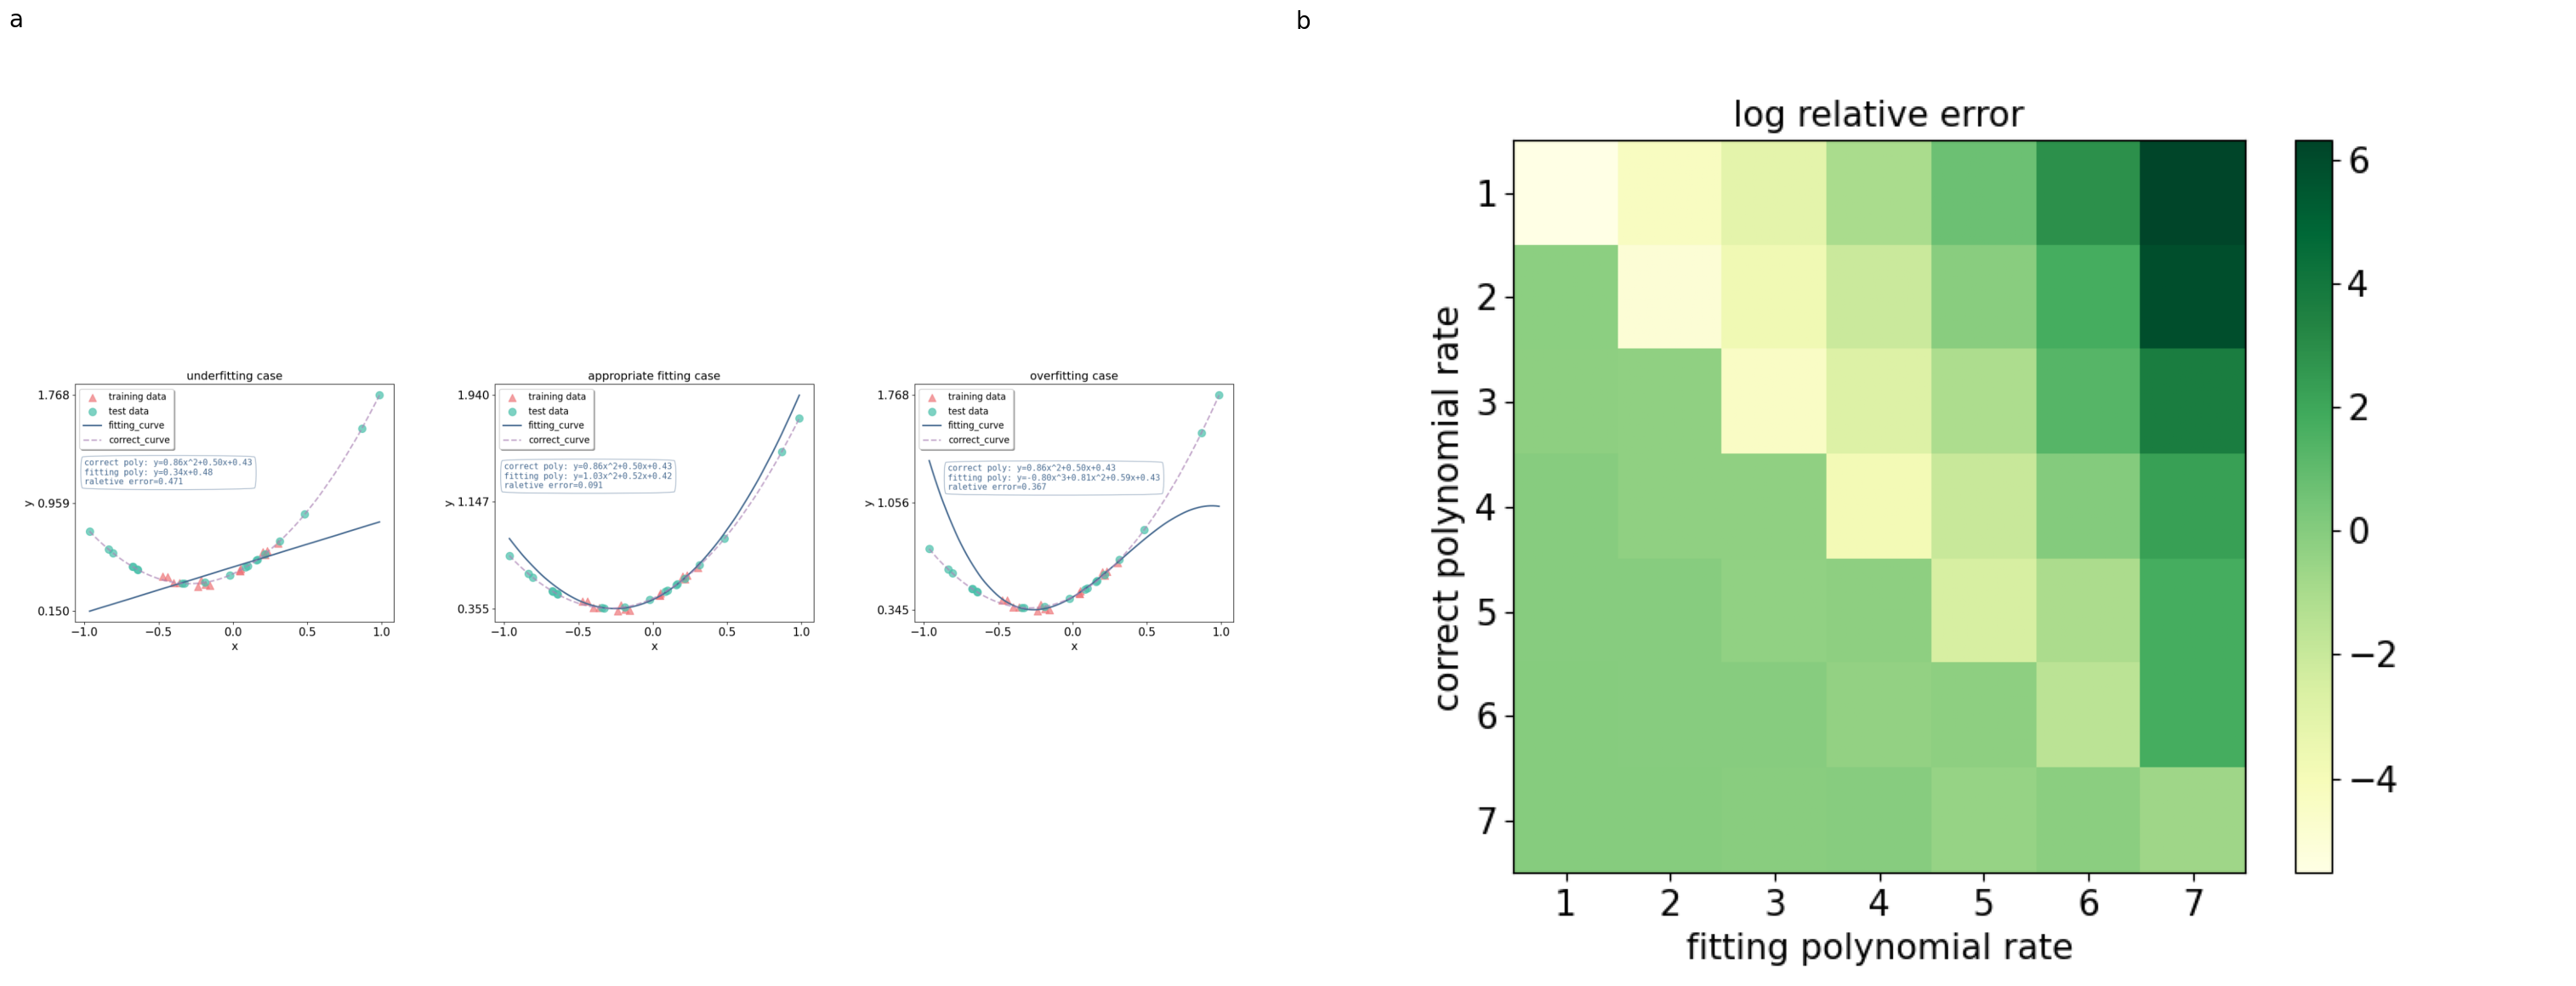

In [419]:
# combine fitting_a.png and fitting_b.png to fitting.png, label fitting_a as a, fitting_b as b
img1 = plt.imread('./figures/fitting_a.png')
img2 = plt.imread('./figures/fitting_b.png')

fig, ax = plt.subplots(1, 2, figsize=(7.6*4, 5.7*4))
ax[0].text(0.5, 0.5, 'a', fontsize=20, ha='center')
ax[0].axis('off')
ax[1].text(0.5, 0.5, 'b', fontsize=20, ha='center')
ax[1].axis('off')

ax[0].imshow(img1)
ax[1].imshow(img2)
plt.tight_layout()
plt.savefig('./figures/fitting.png')
